# TsetlinMachine Model Pipline_Grid Search

### Install Required Py packages

In [ ]:
!pip install pyTsetlinMachine
!pip install split-folders

  Preparing metadata (setup.py) ... done
  Created wheel for pyTsetlinMachine: filename=pyTsetlinMachine-0.6.6-cp310-cp310-linux_x86_64.whl size=59502 sha256=88e34169cef59b191c95c913015b15eca83e204815fc08ff65b7b5704e679d70
  Stored in directory: /root/.cache/pip/wheels/b0/b0/c5/07c4cb8bb93c5325bdc2c2a070b565f54df717d5d11f0c6802
Successfully built pyTsetlinMachine


### Step 1: Import Required Libraries

In [ ]:
import os
import numpy as np
import cv2
from pyTsetlinMachine.tm import MultiClassConvolutionalTsetlinMachine2D
from time import time
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import splitfolders
from torchvision import datasets, transforms
from time import time
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score

### Step 2: Mount Google Drive and Load Dataset

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define paths
data_dir = '/content/drive/My Drive/data'
output_dir = '/content/dataset'

Mounted at /content/drive


## Step 3: Split the Dataset into train ,test and validation sets

In [ ]:
# Split the dataset into train ,test and validation sets
splitfolders.ratio(data_dir, output=output_dir, seed=1337, ratio=(.8, .1, .1))

Copying files: 752 files [00:05, 141.38 files/s]


In [ ]:
# Function to preprocess and convert images to binary
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (28, 28))
    _, img_bin = cv2.threshold(img, 127, 1, cv2.THRESH_BINARY)
    return img_bin

def load_data_as_binary(data_dir):
    X = []
    y = []
    class_names = []
    for class_idx, class_dir in enumerate(sorted(os.listdir(data_dir))):
        class_path = os.path.join(data_dir, class_dir)
        class_names.append(class_dir)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img_bin = preprocess_image(img_path)
                X.append(img_bin)
                y.append(class_idx)
    return np.array(X), np.array(y), class_names

# Convert images to binary format
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')

X_train_bin, y_train_bin, class_names = load_data_as_binary(train_dir)
X_val_bin, y_val_bin, _ = load_data_as_binary(val_dir)
X_test_bin, y_test_bin, _ = load_data_as_binary(test_dir)

# Reshape data to add the channel dimension
X_train_bin = X_train_bin.reshape((X_train_bin.shape[0], 28, 28, 1))
X_val_bin = X_val_bin.reshape((X_val_bin.shape[0], 28, 28, 1))
X_test_bin = X_test_bin.reshape((X_test_bin.shape[0], 28, 28, 1))

### Step 4: Exloratory Data Analysis

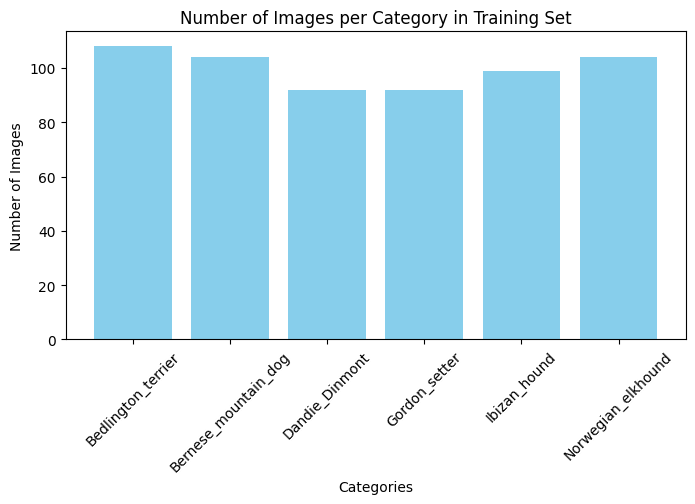

In [ ]:
# Get the class names and number of images in each class
class_counts = [0] * len(class_names)
for label in y_train_bin:
    class_counts[label] += 1

# Plot the bar chart
plt.figure(figsize=(8, 4))
plt.bar(class_names, class_counts, color='skyblue')
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Number of Images per Category in Training Set')
plt.xticks(rotation=45)
plt.show()

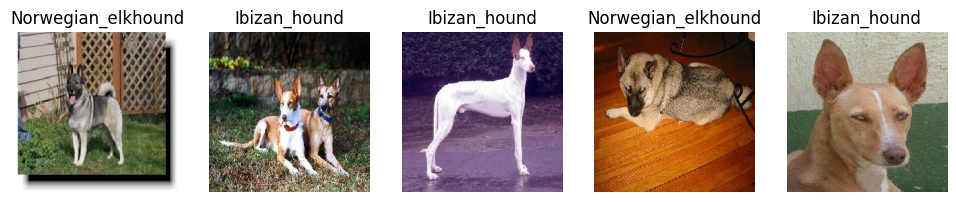

In [ ]:
# Define the transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load the training data
train_data = datasets.ImageFolder('/content/drive/My Drive/data', transform=transform)

# Get the class names
class_names = train_data.classes

# Function to display random images from the dataset
def show_random_images(dataset, num_images=5):
    plt.figure(figsize=(12, 4))
    for i in range(num_images):
        idx = np.random.randint(len(dataset))
        img, label = dataset[idx]
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img.permute(1, 2, 0))
        plt.title(class_names[label])
        plt.axis('off')
    plt.show()

# Display random images from the training dataset
show_random_images(train_data)

### Model Selection and Training
Finding Optimal Model and Hyperparameters for our Model:

In [ ]:
# Define the parameter grid
parameters_grid_tm = {
    "number_of_clauses": [3000, 4000, 5000],
    "T": [40 * 100, 60 * 100, 70 * 100],
    "s": [2.0, 3.0, 5.0,10.0],
    "patch_dim": [(5, 5), (10, 10),(15,15)]
}

# Convert the grid into a list of parameter combinations
param_combinations = list(ParameterGrid(parameters_grid_tm))

# Initialize variables to store the best parameters and the best score
best_params = None
best_score = 0

# Perform grid search
for params in param_combinations:
    print(f"Testing parameters: {params}")

    # Initialize the Tsetlin Machine with current parameters
    tm = MultiClassConvolutionalTsetlinMachine2D(
        number_of_clauses=params["number_of_clauses"],
        T=params["T"],
        s=params["s"],
        patch_dim=params["patch_dim"],
        weighted_clauses=True
    )

    # Train the Tsetlin Machine
    start = time()
    tm.fit(X_train_bin, y_train_bin, epochs=10)
    stop = time()

    # Validate the model
    y_val_pred = tm.predict(X_val_bin)
    accuracy = accuracy_score(y_val_bin, y_val_pred)

    print(f"Validation Accuracy: {accuracy:.2f} (Time: {stop-start:.2f}s)")

    # Check if this is the best score we've seen
    if accuracy > best_score:
        best_score = accuracy
        best_params = params

# Print the best parameters and the best score
print(f"Best Accuracy: {best_score:.2f}")
print(f"Best found hyperparameters for Tsetlin Machine: {best_params}")



Testing parameters: {'T': 4000, 'number_of_clauses': 3000, 'patch_dim': (5, 5), 's': 2.0}
Validation Accuracy: 0.40 (Time: 120.15s)
Testing parameters: {'T': 4000, 'number_of_clauses': 3000, 'patch_dim': (5, 5), 's': 3.0}
Validation Accuracy: 0.41 (Time: 112.94s)
Testing parameters: {'T': 4000, 'number_of_clauses': 3000, 'patch_dim': (5, 5), 's': 5.0}
Validation Accuracy: 0.44 (Time: 109.42s)
Testing parameters: {'T': 4000, 'number_of_clauses': 3000, 'patch_dim': (5, 5), 's': 10.0}
Validation Accuracy: 0.29 (Time: 102.20s)
Testing parameters: {'T': 4000, 'number_of_clauses': 3000, 'patch_dim': (10, 10), 's': 2.0}
Validation Accuracy: 0.44 (Time: 127.26s)
Testing parameters: {'T': 4000, 'number_of_clauses': 3000, 'patch_dim': (10, 10), 's': 3.0}
Validation Accuracy: 0.40 (Time: 113.94s)
Testing parameters: {'T': 4000, 'number_of_clauses': 3000, 'patch_dim': (10, 10), 's': 5.0}
Validation Accuracy: 0.38 (Time: 104.72s)
Testing parameters: {'T': 4000, 'number_of_clauses': 3000, 'patch_dim

1- Best found hyperparameters for Tsetlin Machine: {'T': 4000, 'number_of_clauses': 3000, 'patch_dim': (15, 15), 's': 3.0}  with Accuracy: **0.52**

### Step 5: Model Definition based on Best found hyperparameters

In [ ]:
# Initialize the MultiClassConvolutionalTsetlinMachine2D model
tm = MultiClassConvolutionalTsetlinMachine2D(5000, 30*100, 5.0, (5, 5), weighted_clauses=True)

print("\nAccuracy over 30 epochs:\n")
for i in range(30):
    start = time()
    tm.fit(X_train_bin, y_train_bin, epochs=1, incremental=True)
    stop = time()

    accuracy = 100*(tm.predict(X_val_bin) == y_val_bin).mean()
    print("#%d Accuracy: %.2f%% (%.2fs)" % (i+1, accuracy, stop-start))


Accuracy over 30 epochs:

#1 Accuracy: 23.29% (26.96s)
#2 Accuracy: 26.03% (17.99s)
#3 Accuracy: 21.92% (18.05s)
#4 Accuracy: 32.88% (18.66s)
#5 Accuracy: 32.88% (19.33s)
#6 Accuracy: 39.73% (18.01s)
#7 Accuracy: 32.88% (17.98s)
#8 Accuracy: 36.99% (19.49s)
#9 Accuracy: 34.25% (18.65s)
#10 Accuracy: 41.10% (17.96s)
#11 Accuracy: 36.99% (19.89s)
#12 Accuracy: 32.88% (18.63s)
#13 Accuracy: 36.99% (19.16s)
#14 Accuracy: 45.21% (17.98s)
#15 Accuracy: 41.10% (17.98s)
#16 Accuracy: 45.21% (19.38s)
#17 Accuracy: 39.73% (18.20s)
#18 Accuracy: 39.73% (17.86s)
#19 Accuracy: 41.10% (17.83s)
#20 Accuracy: 41.10% (19.82s)
#21 Accuracy: 46.58% (18.57s)
#22 Accuracy: 46.58% (18.01s)
#23 Accuracy: 41.10% (17.91s)
#24 Accuracy: 45.21% (19.65s)
#25 Accuracy: 42.47% (17.85s)
#26 Accuracy: 43.84% (17.87s)
#27 Accuracy: 41.10% (18.56s)
#28 Accuracy: 42.47% (19.63s)
#29 Accuracy: 42.47% (17.84s)
#30 Accuracy: 47.95% (19.75s)


### Step 6: Model Evaluation

Evaluation of Tsetlin Machine Model
                      precision    recall  f1-score   support

  Bedlington_terrier       0.71      0.33      0.45        15
Bernese_mountain_dog       0.58      0.50      0.54        14
      Dandie_Dinmont       0.47      0.67      0.55        12
       Gordon_setter       0.56      0.77      0.65        13
        Ibizan_hound       0.30      0.23      0.26        13
  Norwegian_elkhound       0.44      0.54      0.48        13

            accuracy                           0.50        80
           macro avg       0.51      0.51      0.49        80
        weighted avg       0.52      0.50      0.49        80



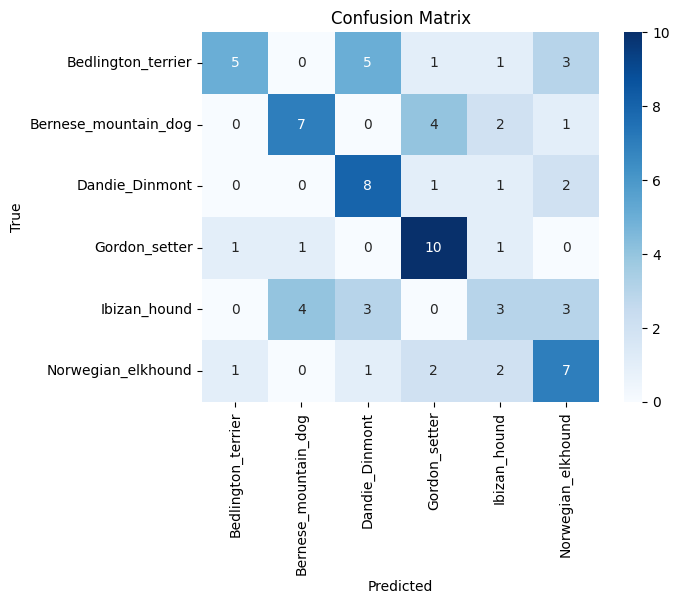

In [ ]:
# Predict on the test set
y_pred_bin = tm.predict(X_test_bin)

# Print evaluation report
print("Evaluation of Tsetlin Machine Model")
print(classification_report(y_test_bin, y_pred_bin, target_names=class_names))

# Print and plot confusion matrix
cm_bin = confusion_matrix(y_test_bin, y_pred_bin)
sns.heatmap(cm_bin, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()